In [1]:
import time

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools

In [41]:
"""@TTbarResAnaHadronic Package to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
"""
class ValPlots(processor.ProcessorABC):
    def __init__(self):
                
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        jeteta_axis = hist.Bin("jeteta", r"Jet $\eta$", 50, -5, 5)
        jetphi_axis = hist.Bin("jetphi", r"Jet $\phi$", 50, -np.pi, np.pi)
        jetmass_axis = hist.Bin("jetmass", r"Jet $m$ [GeV]", 50, 0, 500)
        jetpt_axis = hist.Bin("jetpt", r"Jet $p_{T}$ [GeV]", 50, 0, 5000)

        self._accumulator = processor.dict_accumulator({
            'ak8jetsdmass':   hist.Hist("Counts", dataset_axis, jetmass_axis),
            'ak8jetpt':     hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ak8jeteta':   hist.Hist("Counts", dataset_axis, jeteta_axis),
            'ak8jetphi':     hist.Hist("Counts", dataset_axis, jetphi_axis),
            'cutflow': processor.defaultdict_accumulator(int),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()

        dataset = df['dataset']
        Jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['jet_pt'],
            eta=df['jet_eta'],
            phi=df['jet_phi'],
            mass=df['jet_m'],
            msoftdrop=df['jet_msd']
            )
        
        output['ak8jetpt'].fill(dataset=dataset, 
                            jetpt=Jets.pt[:,0].flatten())
        output['ak8jetsdmass'].fill(dataset=dataset, 
                            jetmass=Jets.msoftdrop[:,0].flatten())
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [42]:

fileset = {
    'QCDflat':['/mnt/data/ml/qcd_flat15to7000_addindices.root'],
    'QCDflatter':['qcd_flatter50to7000.root'],
    'QCDflattest':['qcd_flattest15to7000.root'],
    'Zprime1TeV':['/mnt/data/ml/gravkk_zz_1TeV_addindices.root'],
    'Zprime2TeV':['/mnt/data/ml/gravkk_zz_2TeV_addindices.root'],
    'Zprime3TeV':['/mnt/data/ml/gravkk_zz_3TeV_addindices.root'],
    'ZZ':['zz.root'],
    'ZZflat':['zz_flat.root'],
    'ZZflatter':['zz_flatter.root']
    #'ZZ to 4mu': [
    #    'data/ZZTo4mu.root'
    #]
}

In [43]:
tstart = time.time()
        


output = processor.run_uproot_job(fileset,
                                  treename='T',
                                  processor_instance=ValPlots(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 4, 'flatten': True},
                                  chunksize=500000,
                                 )

elapsed = time.time() - tstart
print(output)


{'ak8jetsdmass': <Hist (dataset,jetmass) instance at 0x7f824c90d320>, 'ak8jetpt': <Hist (dataset,jetpt) instance at 0x7f824a1df0b8>, 'ak8jeteta': <Hist (dataset,jeteta) instance at 0x7f824a1dff60>, 'ak8jetphi': <Hist (dataset,jetphi) instance at 0x7f824a1df908>, 'cutflow': defaultdict(<class 'int'>, {})}


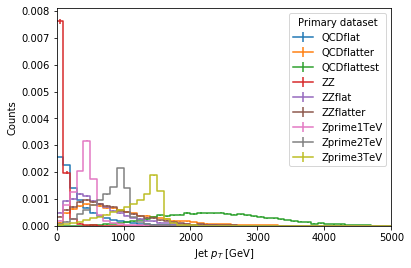

In [44]:
fig, ax = hist.plotgrid(output['ak8jetpt'], overlay="dataset", stack=False, density=True)    
fig.show()

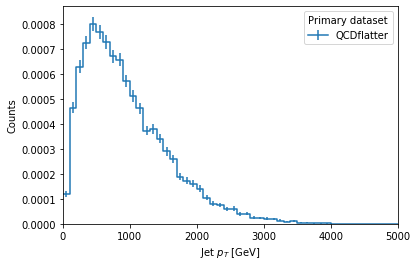

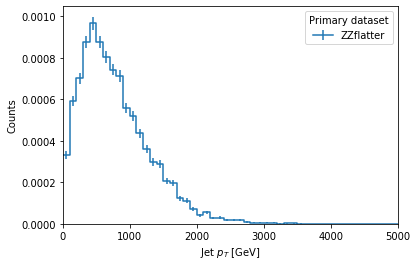

In [45]:
fig, ax = hist.plotgrid(output['ak8jetpt']['QCDflatter'], overlay="dataset", stack=False, density=True)
fig, ax = hist.plotgrid(output['ak8jetpt']['ZZflatter'], overlay="dataset", stack=False, density=True)
fig.show()

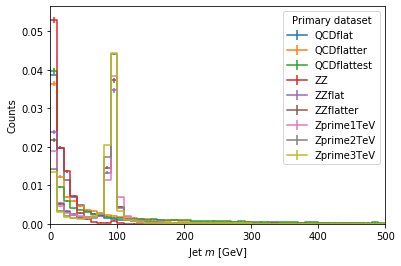

In [47]:
fig, ax = hist.plotgrid(output['ak8jetsdmass'], overlay="dataset", stack=False, density=True)    
fig.show()

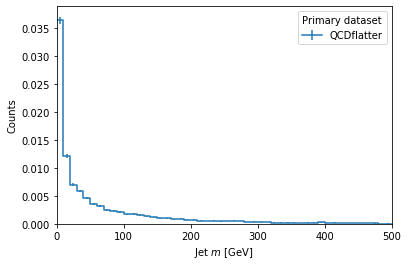

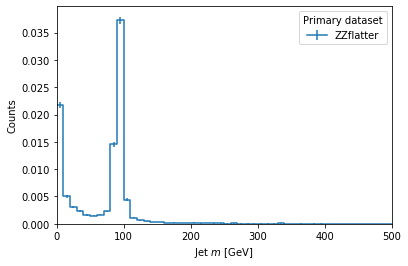

In [48]:
fig, ax = hist.plotgrid(output['ak8jetsdmass']['QCDflatter'], overlay="dataset", stack=False, density=True)
fig, ax = hist.plotgrid(output['ak8jetsdmass']['ZZflatter'], overlay="dataset", stack=False, density=True)
fig.show()